In [65]:
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 1
%aimport visualization.vis
%aimport utils.utils

In [66]:
import pytorch_lightning as pl
import cv2
import matplotlib.pyplot as plt
import io

from torch_geometric.loader import DataLoader
from argparse import ArgumentParser
from datasets import ArgoverseV2Dataset
from predictors import QCNet
from predictors.autoval import AntoQCNet
from predictors.environment import WorldModel
from transforms import TargetBuilder
from av2.datasets.motion_forecasting import scenario_serialization
from av2.datasets.motion_forecasting.data_schema import (
    ArgoverseScenario,
    ObjectType,
    TrackCategory,
)
from av2.map.map_api import ArgoverseStaticMap
from pathlib import Path
from visualization.vis import plot_traj_with_data, plot_traj, vis_reward, generate_video
from utils.utils import get_transform_mat, get_auto_pred, add_new_agent, reward_function

pl.seed_everything(2023, workers=True)

parser = ArgumentParser()
parser.add_argument("--model", type=str, default="QCNet")
parser.add_argument("--root", type=str, default="/home/guanren/Multi-agent-competitive-environment/datasets")
parser.add_argument("--batch_size", type=int, default=1)
parser.add_argument("--num_workers", type=int, default=8)
parser.add_argument("--pin_memory", type=bool, default=True)
parser.add_argument("--persistent_workers", type=bool, default=True)
parser.add_argument("--accelerator", type=str, default="auto")
parser.add_argument("--devices", type=int, default=1)
parser.add_argument("--ckpt_path", default="checkpoints/epoch=10-step=274879.ckpt", type=str)
args = parser.parse_args("")

model = {
    "QCNet": AntoQCNet,
}[args.model].load_from_checkpoint(checkpoint_path=args.ckpt_path)
environment = {
    "QCNet": WorldModel,
}[args.model].load_from_checkpoint(checkpoint_path=args.ckpt_path)
val_dataset = {
    "argoverse_v2": ArgoverseV2Dataset,
}[model.dataset](
    root=args.root,
    split="val",
    transform=TargetBuilder(model.num_historical_steps, model.num_future_steps),
)


Global seed set to 2023
/home/guanren/anaconda3/envs/QCNet/lib/python3.8/site-packages/pytorch_lightning/utilities/migration/utils.py:51: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.1.1, which is newer than your current Lightning version: v2.0.4
  rank_zero_warn(


In [67]:
dataloader = DataLoader(
    # val_dataset[[val_dataset.raw_file_names.index('0a8dd03b-02cf-4d7b-ae7f-c9e65ad3c900')]],
    val_dataset[[val_dataset.raw_file_names.index('0a0ef009-9d44-4399-99e6-50004d345f34')]],
    # val_dataset[[val_dataset.raw_file_names.index('0a09b183-3553-4c85-9a12-976409e4aeab')]],
    # val_dataset[[val_dataset.raw_file_names.index('00a9541f-a00c-45c6-9071-dec34f5f818b')]],
    # val_dataset[[val_dataset.raw_file_names.index('0aa35936-8a93-4174-8491-ee4b0bece920')]],
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=args.pin_memory,
    persistent_workers=args.persistent_workers,
)

trainer = pl.Trainer(accelerator=args.accelerator, devices=args.devices)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [68]:
it = iter(dataloader)
data = next(it)

/home/guanren/anaconda3/envs/QCNet/lib/python3.8/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


/home/guanren/Multi-agent-competitive-environment/datasets/val/raw/8ff85423-3f41-49c1-b81f-dfabd54a1a90/scenario_8ff85423-3f41-49c1-b81f-dfabd54a1a90.parquet


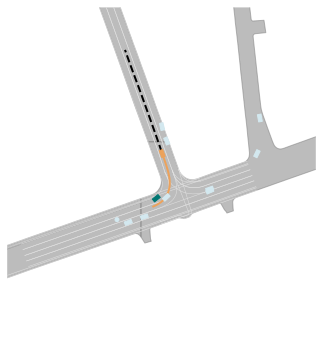

In [69]:

scenario_id = data["scenario_id"][0]
argoverse_scenario_dir = Path("/home/guanren/Multi-agent-competitive-environment/datasets/val/raw")

all_scenario_files = sorted(argoverse_scenario_dir.rglob(f"*_{scenario_id}.parquet"))
scenario_file_list = list(all_scenario_files)
scenario_path = scenario_file_list[0]
print(scenario_path)

static_map_path = scenario_path.parents[0] / f"log_map_archive_{scenario_id}.json"

scenario = scenario_serialization.load_argoverse_scenario_parquet(scenario_path)
scenario_static_map = ArgoverseStaticMap.from_json(static_map_path)
plot_traj(scenario_static_map,scenario)

In [70]:

for param in model.encoder.parameters():
        param.requires_grad = False
for param in model.decoder.parameters():
        param.requires_grad = False

from torch_geometric.data import Batch
from utils import wrap_angle
import torch, math
import copy
import numpy as np

if isinstance(data, Batch):
    data['agent']['av_index'] += data['agent']['ptr'][:-1]

tensor([[5261.6440,  323.5610],
        [5261.3530,  324.4183],
        [5261.0596,  325.2813],
        [5260.7603,  326.1551],
        [5260.4556,  327.0402],
        [5260.1484,  327.9317],
        [5259.8408,  328.8277],
        [5259.5317,  329.7279],
        [5259.2192,  330.6354],
        [5258.9023,  331.5485],
        [5258.5825,  332.4653],
        [5258.2593,  333.3869],
        [5257.9316,  334.3120],
        [5257.5981,  335.2398],
        [5257.2607,  336.1723],
        [5256.9219,  337.1104],
        [5256.5854,  338.0492],
        [5256.2520,  338.9900],
        [5255.9160,  339.9392],
        [5255.5776,  340.8939],
        [5255.2354,  341.8530],
        [5254.8901,  342.8162],
        [5254.5420,  343.7852],
        [5254.1934,  344.7569],
        [5253.8462,  345.7260],
        [5253.5000,  346.6940],
        [5253.1528,  347.6625],
        [5252.8052,  348.6328],
        [5252.4575,  349.6055],
        [5252.1069,  350.5837],
        [5251.7534,  351.5680],
        

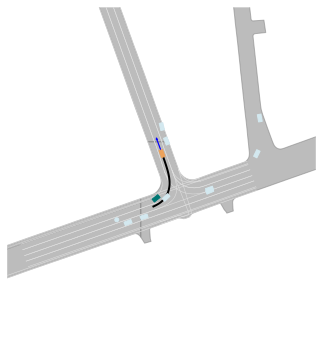

In [71]:
plot_traj_with_data(data,scenario_static_map,1,t=50)
agent_index = torch.nonzero(data['agent']['category']==3,as_tuple=False).item()
print(data['agent']['position'][agent_index,50:,:2])
print(data['agent']['heading'][agent_index,50:])

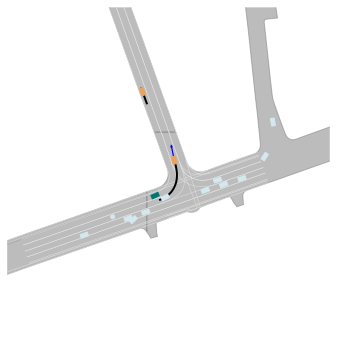

In [79]:

# v0_x = 5*math.cos(1.28)
# v0_y = math.sqrt(5**2-v0_x**2)
# new_input_data=add_new_agent(data,0.3, v0_x, v0_y, 1.28, 2673, -2410)
# v0_x = 5*math.cos(-1.95)
# v0_y = -math.sqrt(5**2-v0_x**2)
# new_input_data=add_new_agent(new_input_data,0.3, v0_x, v0_y, -1.95, 2693, -2340)
# v0_x = -5*math.cos(-0.33)
# v0_y = math.sqrt(5**2-v0_x**2)
# new_input_data=add_new_agent(new_input_data,-0.3, v0_x, v0_y, -0.33, 2725, -2381)

v0_x = 1*math.cos(1.9338)
v0_y = math.sqrt(1**2-v0_x**2)
new_input_data=add_new_agent(data,0.3, v0_x, v0_y, 1.9338, 5250, 345)
v0_x = 1*math.cos(5.07)
v0_y = -math.sqrt(1**2-v0_x**2)
new_input_data=add_new_agent(new_input_data,0.3, v0_x, v0_y, 5.07, 5227, 407)
v0_x = 1*math.cos(5.07)
v0_y = -math.sqrt(1**2-v0_x**2)
new_input_data=add_new_agent(new_input_data,0.3, v0_x, v0_y, 5.07, 5229.7, 411)


# v0_x = 5*math.cos(0.1)
# v0_y = math.sqrt(5**2-v0_x**2)
# new_input_data=add_new_agent(data,1.0, v0_x, v0_y, 0.1, -8379.8809, -828.5)
# v0_x = 5*math.cos(3.15)
# v0_y = math.sqrt(5**2-v0_x**2)
# new_input_data=add_new_agent(new_input_data,0.8, v0_x, v0_y, 3.15, -8311, -823)
# v0_x = -5*math.cos(1.8)
# v0_y = math.sqrt(5**2-v0_x**2)
# new_input_data=add_new_agent(new_input_data,0.5, v0_x, v0_y, 1.8, -8339, -853)
# v0_x = 5*math.cos(4.76)
# v0_y = -math.sqrt(5**2-v0_x**2)
# new_input_data=add_new_agent(new_input_data,0.5, v0_x, v0_y, 4.76, -8345, -793)
# new_input_data=add_new_agent(new_input_data,0, 0, 0, 1.57, -8340, -813)


# v0_x = 5*math.cos(-0.5)
# v0_y = -math.sqrt(5**2-v0_x**2)
# new_input_data=add_new_agent(data,0.1, v0_x, v0_y, -0.5, 691, -904)
# v0_x = 5*math.cos(1.3)
# v0_y = math.sqrt(5**2-v0_x**2)
# new_input_data=add_new_agent(new_input_data,0.3, v0_x, v0_y, 1.3, 695, -950)
# v0_x = 5*math.cos(2.9)
# v0_y = math.sqrt(5**2-v0_x**2)
# new_input_data=add_new_agent(new_input_data,0.3, v0_x, v0_y, 2.9, 735, -919)
# new_input_data=add_new_agent(new_input_data,0, 0, 0, 1.0, 698, -924.5)

plot_traj_with_data(new_input_data,scenario_static_map, 4, bounds=80,t=40)

In [126]:
vid_path = "test3.webm"
generate_video(new_input_data,scenario_static_map, model, vid_path)

tensor([[3.6429, 3.7975, 3.6797, 3.7399, 3.6685, 3.9662]], device='cuda:0')
tensor([[6.5542, 6.6159, 6.6035, 6.7271, 6.7294, 6.7857]], device='cuda:0')
tensor([[9.4265, 9.4111, 9.4042, 9.4555, 9.4685, 9.5450]], device='cuda:0')
tensor([[12.0217, 12.0212, 11.9843, 12.0299, 12.0573, 12.0689]],
       device='cuda:0')
tensor([[14.2797, 14.3636, 14.3085, 14.4309, 14.3683, 14.4196]],
       device='cuda:0')
tensor([[16.3899, 16.5254, 16.4566, 16.5982, 16.5483, 16.5951]],
       device='cuda:0')
tensor([[18.6265, 18.7499, 18.7481, 18.8375, 18.7843, 18.8508]],
       device='cuda:0')
tensor([[21.4343, 21.4572, 21.4579, 21.5240, 21.5086, 21.5826]],
       device='cuda:0')
tensor([[24.7411, 24.6762, 24.6524, 24.7265, 24.7120, 24.7488]],
       device='cuda:0')
tensor([[28.4737, 28.4114, 28.3739, 28.4596, 28.4184, 28.5002]],
       device='cuda:0')
tensor([[32.6588, 32.6075, 32.5803, 32.6603, 32.6356, 32.7158]],
       device='cuda:0')
tensor([[37.3929, 37.3412, 37.3136, 37.3998, 37.3726, 37.443

OpenCV: FFMPEG: tag 0x30385056/'VP80' is not supported with codec id 139 and format 'webm / WebM'


/tmp/ipykernel_269589/1622738850.py:243: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  vehicle_bounding_box = Rectangle(


IndexError: The shape of the mask [29] at index 0 does not match the shape of the indexed tensor [30, 6, 60, 4] at index 0

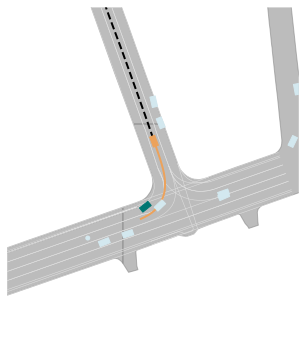

In [ ]:
plot_traj(50.0)
for i in range(6):
    xy = true_traj_refine[[data["agent"]["category"] == 2]][0].cpu().detach()
    plt.plot(xy[i, ..., 0], xy[i, ..., 1])
# for i in range(6):
#     xy = new_position[1][data["agent"]["category"] == 3][0].cpu().detach()
#     plt.plot(xy[i, ..., 0], xy[i, ..., 1])


In [ ]:
[x.value for x in _STATIC_OBJECT_TYPES]

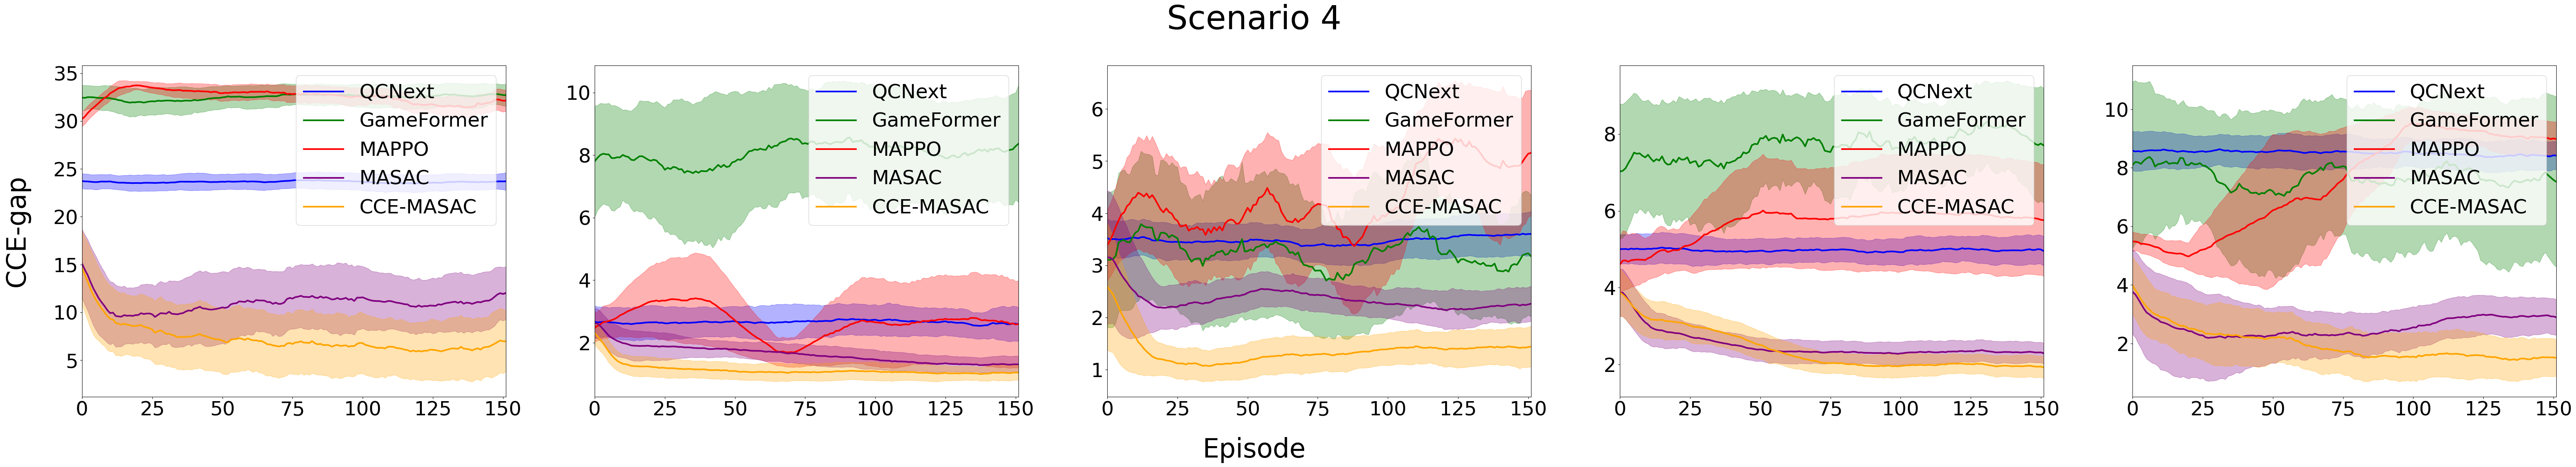

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

agent_number = 5
scenario_number = 3
choose_episode = 151
fig, axs = plt.subplots(1, agent_number, figsize=(66, 12), sharex=True, sharey=False)
datas = []
labels = ['QCNext','GameFormer','MAPPO','MASAC', 'CCE-MASAC']
colors = ['blue', 'green', 'red','purple','orange']

for j in range(agent_number):
    for i in range(0,3*5,3):
        file_paths = [
          f'/home/guanren/Multi-agent-competitive-environment/figures/BC_seed666_scenario{scenario_number}_agent-number{agent_number}.csv',
          f'/home/guanren/Multi-agent-competitive-environment/figures/BC_seed1000_scenario{scenario_number}_agent-number{agent_number}.csv',
          f'/home/guanren/Multi-agent-competitive-environment/figures/BC_seed1666_scenario{scenario_number}_agent-number{agent_number}.csv',

          f'/home/guanren/Multi-agent-competitive-environment/figures/version_7/gameformer_seed666_scenario4_agent-number{agent_number}.csv',
          f'/home/guanren/Multi-agent-competitive-environment/figures/version_7/gameformer_seed1000_scenario4_agent-number{agent_number}.csv',
          f'/home/guanren/Multi-agent-competitive-environment/figures/version_7/gameformer_seed1666_scenario4_agent-number{agent_number}.csv',

          f'/home/guanren/Multi-agent-competitive-environment/figures/version_3/MAPPO_seed666_scenario{scenario_number}_agent-number{agent_number}.csv',
          f'/home/guanren/Multi-agent-competitive-environment/figures/version_3/MAPPO_seed1000_scenario{scenario_number}_agent-number{agent_number}.csv',
          f'/home/guanren/Multi-agent-competitive-environment/figures/version_3/MAPPO_seed1666_scenario{scenario_number}_agent-number{agent_number}.csv',

          f'/home/guanren/Multi-agent-competitive-environment/figures/version_3/MASAC_seed666_scenario{scenario_number}_agent-number{agent_number}.csv',
          f'/home/guanren/Multi-agent-competitive-environment/figures/version_3/MASAC_seed1000_scenario{scenario_number}_agent-number{agent_number}.csv',
          f'/home/guanren/Multi-agent-competitive-environment/figures/version_3/MASAC_seed1666_scenario{scenario_number}_agent-number{agent_number}.csv',

          f'/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed666_scenario{scenario_number}_agent-number{agent_number}.csv',
          f'/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1000_scenario{scenario_number}_agent-number{agent_number}.csv',
          f'/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1666_scenario{scenario_number}_agent-number{agent_number}.csv',
        ]
        expert_data = [
          f'/home/guanren/Multi-agent-competitive-environment/performance/scenario{scenario_number}/CCE-GAP/CCE-MASAC/expert_CCE-MASAC_seed666_scenario{scenario_number}/expert_CCE-MASAC_seed666_scenario{scenario_number}_CCE-GAP_agent{j+1}.csv',
          f'/home/guanren/Multi-agent-competitive-environment/performance/scenario{scenario_number}/CCE-GAP/CCE-MASAC/expert_CCE-MASAC_seed1000_scenario{scenario_number}/expert_CCE-MASAC_seed1000_scenario{scenario_number}_CCE-GAP_agent{j+1}.csv',
          f'/home/guanren/Multi-agent-competitive-environment/performance/scenario{scenario_number}/CCE-GAP/CCE-MASAC/expert_CCE-MASAC_seed1666_scenario{scenario_number}/expert_CCE-MASAC_seed1666_scenario{scenario_number}_CCE-GAP_agent{j+1}.csv'
        ]

        df_list = []
        for idx, path in enumerate(file_paths[i:i + 3]):
            # if i==3 and idx==0:
            #     continue
            data = pd.read_csv(path, header=None, usecols=[j]).squeeze()
            expert = pd.read_csv(expert_data[idx], header=None, usecols=[0]).squeeze()
            df_list.append(abs(expert - data))

        df_combined = pd.concat(df_list, axis=1)

        window_size = 30
        filter_window = np.ones(window_size) / window_size
        
        convolved_mean = np.convolve(df_combined.mean(axis=1), filter_window, 'valid')
        convolved_std = np.convolve(df_combined.std(axis=1), filter_window, 'valid')
        

        axs[j].plot(convolved_mean, label=labels[int(i / 3)], color=colors[int(i / 3)], linewidth=3)
        if ((j==0 or j==1 or j==2) and i==6 and (scenario_number==2 or scenario_number==3)) or (i==3 and (j==2 or j==3)):
            axs[j].fill_between(range(len(convolved_mean)), convolved_mean + convolved_std * 0.6, convolved_mean - convolved_std * 0.6, color=colors[int(i / 3)], alpha=0.3)
        else:
            axs[j].fill_between(range(len(convolved_mean)), convolved_mean + convolved_std * 0.95, convolved_mean - convolved_std * 0.95, color=colors[int(i / 3)], alpha=0.3)



for ax in axs:
    ax.legend(fontsize=36, loc='upper right')
    ax.tick_params(axis='both', labelsize=36)

fig.suptitle(f'Scenario 4', fontsize=60)
fig.supxlabel('Episode', fontsize=48)
fig.supylabel('CCE-gap', fontsize=48)
plt.subplots_adjust(left=0.05,right=1,top=0.85,bottom=0.15,
                    wspace=0.21,hspace=0)
plt.xlim(0, choose_episode)
plt.xticks(np.arange(0, choose_episode, step=25))
plt.savefig("/home/guanren/Multi-agent-competitive-environment/results/scenario4_cce-gap.png")
plt.show()

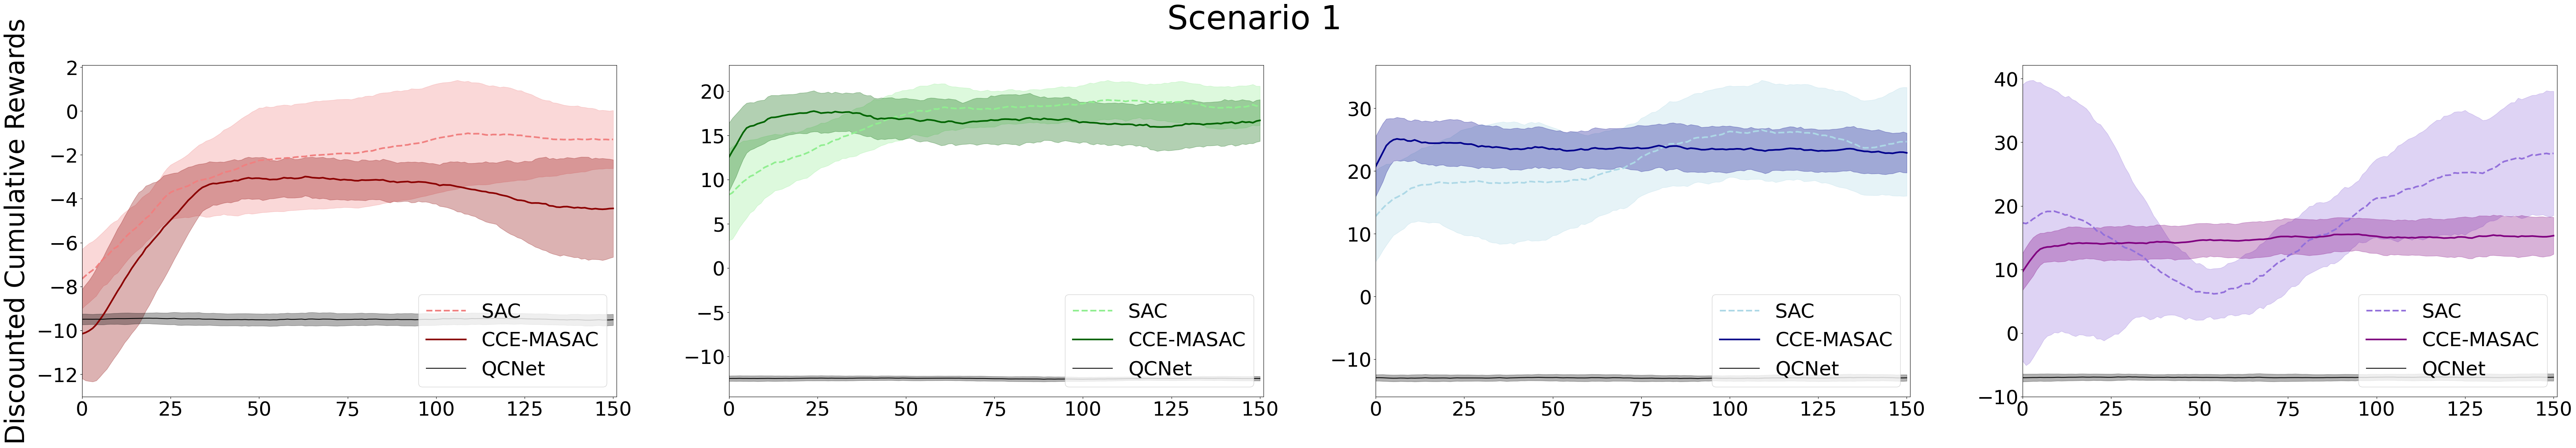

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

agent_number = 4
scenario_number = 1
window_size = 30
fig, axs = plt.subplots(1, agent_number, figsize=(66, 12), sharex=True, sharey=False)

datas = []

choose_episode = 151
labels = ['SAC', 'CCE-MASAC','QCNet']
dark_colors = ['darkred', 'darkgreen', 'darkblue', 'purple', 'darkorange']
light_colors = ['lightcoral', 'lightgreen', 'lightblue', 'mediumpurple', 'gold']
file_paths1 = [
    #scenario1
    '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed666_scenario1_agent3_agent-number1.csv',
    '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed1000_scenario1_agent3_agent-number1.csv',
    '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed1666_scenario1_agent3_agent-number1.csv',
    
    #scenario2
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed666_scenario2_agent6_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed1000_scenario2_agent6_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed1666_scenario2_agent6_agent-number1.csv'

    #scenario3
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed666_scenario3_agent3_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed1000_scenario3_agent3_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed1666_scenario3_agent3_agent-number1.csv',

    #scenario4
    # #'/home/guanren/Multi-agent-competitive-environment/figures/SAC_seed1666_scenario4_agent9_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/SAC_seed666_scenario4_agent9_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/SAC_seed1000_scenario4_agent9_agent-number1.csv'
]
df_list = []
for idx, path in enumerate(file_paths1):
    data = pd.read_csv(path, header=None, usecols=[0]).squeeze()
    df_list.append(data)
df_combined = pd.concat(df_list, axis=1)
datas.append(df_combined)

file_paths2 = [
    #scenario1
    '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed666_scenario1_agent-number4.csv',
    '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1000_scenario1_agent-number4.csv',
    '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1666_scenario1_agent-number4.csv',

    #scenario2
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed666_scenario2_agent-number4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1000_scenario2_agent-number4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1666_scenario2_agent-number4.csv'

    #scenario3
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed666_scenario3_agent-number5.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1000_scenario3_agent-number5.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1666_scenario3_agent-number5.csv'

    #scenario4
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed666_scenario4_agent-number4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1666_scenario4_agent-number4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1000_scenario4_agent-number4.csv'
]
df_list = []
for idx, path in enumerate(file_paths2):
    data = pd.read_csv(path, header=None, usecols=[0]).squeeze()
    df_list.append(data)
df_combined = pd.concat(df_list, axis=1)
datas.append(df_combined)

file_paths3 = [
    #scenario1
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed666_scenario1/QCNet_seed666_scenario1_agent1.csv',
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed1000_scenario1/QCNet_seed1000_scenario1_agent1.csv',
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed1666_scenario1/QCNet_seed1666_scenario1_agent1.csv',

    #scenario2
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed666_scenario2/QCNet_seed666_scenario2_agent1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed1000_scenario2/QCNet_seed1000_scenario2_agent1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed1666_scenario2/QCNet_seed1666_scenario2_agent1.csv',

    #scenario3
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed666_scenario3/QCNet_seed666_scenario3_agent1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1000_scenario3/QCNet_seed1000_scenario3_agent1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1666_scenario3/QCNet_seed1666_scenario3_agent1.csv',


    #scenario4
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario4/reward/QCNet/QCNet_seed666_scenario4/QCNet_seed666_scenario4_agent4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario4/reward/QCNet/QCNet_seed1666_scenario4/QCNet_seed1666_scenario4_agent4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario4/reward/QCNet/QCNet_seed1000_scenario4/QCNet_seed1000_scenario4_agent4.csv'
]
df_list = []
for idx, path in enumerate(file_paths3):
    data = pd.read_csv(path, header=None, usecols=[0]).squeeze()
    df_list.append(data)
df_combined = pd.concat(df_list, axis=1)
datas.append(df_combined)

for i in range(3):
    filter_window = np.ones(window_size) / window_size

    mean_values = np.convolve(datas[i].mean(axis=1), filter_window, 'valid')[:choose_episode]
    std_values = np.convolve(datas[i].std(axis=1), filter_window, 'valid')[:choose_episode]
    if i == 1:
        axs[0].plot(mean_values, label=labels[i], color=dark_colors[0], linestyle='solid', linewidth=3)
        axs[0].fill_between(range(len(mean_values)), mean_values+std_values, mean_values-std_values, color=dark_colors[0], alpha=0.3)
    elif i ==0:
        axs[0].plot(mean_values, label=labels[i], color=light_colors[0], linestyle='dashed', linewidth=3)
        axs[0].fill_between(range(len(mean_values)), mean_values+std_values, mean_values-std_values, color=light_colors[0], alpha=0.3)
    else:
        axs[0].plot(mean_values, label=labels[i], color='black', linestyle='solid')
        axs[0].fill_between(range(len(mean_values)), mean_values+std_values, mean_values-std_values, color='black', alpha=0.3)

datas = []
file_paths1 = [
    #scenario1
    '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed666_scenario1_agent-3_agent-number1.csv',
    '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed1000_scenario1_agent-3_agent-number1.csv',
    '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed1666_scenario1_agent-3_agent-number1.csv',
    
    #scenario2
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed1000_scenario2_agent-3_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed666_scenario2_agent-3_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed1666_scenario2_agent-3_agent-number1.csv'

    #scenario3
    # '/home/guanren/Multi-agent-competitive-environment/figures/SAC_seed666_scenario3_agent-4_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/SAC_seed1000_scenario3_agent-4_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/SAC_seed1666_scenario3_agent-4_agent-number1.csv',

    #scenario4
    # '/home/guanren/Multi-agent-competitive-environment/figures/SAC_seed1666_scenario4_agent-3_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/SAC_seed666_scenario4_agent-3_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/SAC_seed1000_scenario4_agent-3_agent-number1.csv'
]
df_list = []
for idx, path in enumerate(file_paths1):
    data = pd.read_csv(path, header=None, usecols=[0]).squeeze()
    df_list.append(data)
df_combined = pd.concat(df_list, axis=1)
datas.append(df_combined)

file_paths2 = [
    #scenario1
    '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed666_scenario1_agent-number4.csv',
    '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1000_scenario1_agent-number4.csv',
    '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1666_scenario1_agent-number4.csv',

    #scenario2
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed666_scenario2_agent-number4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1000_scenario2_agent-number4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1666_scenario2_agent-number4.csv',

    #scenario3
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed666_scenario3_agent-number5.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1000_scenario3_agent-number5.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1666_scenario3_agent-number5.csv'

    #scenario4
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed666_scenario4_agent-number4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1666_scenario4_agent-number4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1000_scenario4_agent-number4.csv'
]
df_list = []
for idx, path in enumerate(file_paths2):
    data = pd.read_csv(path, header=None, usecols=[1]).squeeze()
    df_list.append(data)
df_combined = pd.concat(df_list, axis=1)
datas.append(df_combined)

file_paths3 = [
    #scenario1
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed666_scenario1/QCNet_seed666_scenario1_agent2.csv',
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed1000_scenario1/QCNet_seed1000_scenario1_agent2.csv',
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed1666_scenario1/QCNet_seed1666_scenario1_agent2.csv',

    #scenario2
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed666_scenario2/QCNet_seed666_scenario2_agent2.csv',
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed1000_scenario2/QCNet_seed1000_scenario2_agent2.csv',
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed1666_scenario2/QCNet_seed1666_scenario2_agent2.csv',

    #scenario3
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed666_scenario3/QCNet_seed666_scenario3_agent2.csv',
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1000_scenario3/QCNet_seed1000_scenario3_agent2.csv',
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1666_scenario3/QCNet_seed1666_scenario3_agent2.csv',

    #scenario4
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario4/reward/QCNet/QCNet_seed666_scenario4/QCNet_seed666_scenario4_agent4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario4/reward/QCNet/QCNet_seed1666_scenario4/QCNet_seed1666_scenario4_agent4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario4/reward/QCNet/QCNet_seed1000_scenario4/QCNet_seed1000_scenario4_agent4.csv'
]
df_list = []
for idx, path in enumerate(file_paths3):
    data = pd.read_csv(path, header=None, usecols=[0]).squeeze()
    df_list.append(data)
df_combined = pd.concat(df_list, axis=1)
datas.append(df_combined)

for i in range(3):
    filter_window = np.ones(window_size) / window_size

    mean_values = np.convolve(datas[i].mean(axis=1), filter_window, 'valid')[:choose_episode]
    std_values = np.convolve(datas[i].std(axis=1), filter_window, 'valid')[:choose_episode]
    if i == 1:
        axs[1].plot(mean_values, label=labels[i], color=dark_colors[1], linestyle='solid', linewidth=3)
        axs[1].fill_between(range(len(mean_values)), mean_values+std_values, mean_values-std_values, color=dark_colors[1], alpha=0.3)
    elif i ==0:
        axs[1].plot(mean_values, label=labels[i], color=light_colors[1], linestyle='dashed', linewidth=3)
        axs[1].fill_between(range(len(mean_values)), mean_values+std_values, mean_values-std_values, color=light_colors[1], alpha=0.3)
    else:
        axs[1].plot(mean_values, label=labels[i], color='black', linestyle='solid')
        axs[1].fill_between(range(len(mean_values)), mean_values+std_values, mean_values-std_values, color='black', alpha=0.3)

datas = []
file_paths1 = [
    #scenario1
    '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed666_scenario1_agent-2_agent-number1.csv',
    '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed1000_scenario1_agent-2_agent-number1.csv',
    '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed1666_scenario1_agent-2_agent-number1.csv',
    
    #scenario2
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed666_scenario2_agent-2_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed1000_scenario2_agent-2_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed1666_scenario2_agent-2_agent-number1.csv'

    #scenario3
    # '/home/guanren/Multi-agent-competitive-environment/figures/SAC_seed666_scenario3_agent-3_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/SAC_seed1666_scenario3_agent-3_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/SAC_seed1000_scenario3_agent-3_agent-number1.csv',

    #scenario4
    # '/home/guanren/Multi-agent-competitive-environment/figures/SAC_seed1666_scenario4_agent-2_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/SAC_seed666_scenario4_agent-2_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/SAC_seed1000_scenario4_agent-2_agent-number1.csv'
]
df_list = []
for idx, path in enumerate(file_paths1):
    data = pd.read_csv(path, header=None, usecols=[0]).squeeze()
    df_list.append(data)
df_combined = pd.concat(df_list, axis=1)
datas.append(df_combined)

file_paths2 = [
    #scenario1
    '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed666_scenario1_agent-number4.csv',
    '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1000_scenario1_agent-number4.csv',
    '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1666_scenario1_agent-number4.csv',

    #scenario2
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed666_scenario2_agent-number4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1000_scenario2_agent-number4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1234_scenario2_agent-number4.csv'

    #scenario3
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed666_scenario3_agent-number5.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1000_scenario3_agent-number5.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1666_scenario3_agent-number5.csv'

    #scenario4
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed666_scenario4_agent-number4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1666_scenario4_agent-number4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1000_scenario4_agent-number4.csv'
    
]
df_list = []
for idx, path in enumerate(file_paths2):
    data = pd.read_csv(path, header=None, usecols=[2]).squeeze()
    df_list.append(data)
df_combined = pd.concat(df_list, axis=1)
datas.append(df_combined)

file_paths3 = [
    #scenario1
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed666_scenario1/QCNet_seed666_scenario1_agent3.csv',
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed1000_scenario1/QCNet_seed1000_scenario1_agent3.csv',
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed1666_scenario1/QCNet_seed1666_scenario1_agent3.csv',

    #scenario2
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed666_scenario2/QCNet_seed666_scenario2_agent3.csv',
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed1000_scenario2/QCNet_seed1000_scenario2_agent3.csv',
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed1666_scenario2/QCNet_seed1666_scenario2_agent3.csv',

    #scenario3
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed666_scenario3/QCNet_seed666_scenario3_agent3.csv',
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1000_scenario3/QCNet_seed1000_scenario3_agent3.csv',
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1666_scenario3/QCNet_seed1666_scenario3_agent3.csv',

    #scenario4
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario4/reward/QCNet/QCNet_seed666_scenario4/QCNet_seed666_scenario4_agent4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario4/reward/QCNet/QCNet_seed1666_scenario4/QCNet_seed1666_scenario4_agent4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario4/reward/QCNet/QCNet_seed1000_scenario4/QCNet_seed1000_scenario4_agent4.csv'
]
df_list = []
for idx, path in enumerate(file_paths3):
    data = pd.read_csv(path, header=None, usecols=[0]).squeeze()
    df_list.append(data)
df_combined = pd.concat(df_list, axis=1)
datas.append(df_combined)

for i in range(3):
    filter_window = np.ones(window_size) / window_size

    mean_values = np.convolve(datas[i].mean(axis=1), filter_window, 'valid')[:choose_episode]
    std_values = np.convolve(datas[i].std(axis=1), filter_window, 'valid')[:choose_episode]
    if i == 1:
        axs[2].plot(mean_values, label=labels[i], color=dark_colors[2], linestyle='solid', linewidth=3)
        axs[2].fill_between(range(len(mean_values)), mean_values+std_values, mean_values-std_values, color=dark_colors[2], alpha=0.3)
    elif i ==0:
        axs[2].plot(mean_values, label=labels[i], color=light_colors[2], linestyle='dashed', linewidth=3)
        axs[2].fill_between(range(len(mean_values)), mean_values+std_values, mean_values-std_values, color=light_colors[2], alpha=0.3)
    else:
        axs[2].plot(mean_values, label=labels[i], color='black', linestyle='solid')
        axs[2].fill_between(range(len(mean_values)), mean_values+std_values, mean_values-std_values, color='black', alpha=0.3)

datas = []
file_paths1 = [
    #scenario1
    #'/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed666_scenario1_agent-1_agent-number1.csv',
    '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed1666_scenario1_agent-1_agent-number1.csv',
    '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed1000_scenario1_agent-1_agent-number1.csv',
    
    #scenario2
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed666_scenario2_agent-1_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed1000_scenario2_agent-1_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed1666_scenario2_agent-1_agent-number1.csv'

    #scenario3
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed666_scenario3_agent-2_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed1000_scenario3_agent-2_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_2/SAC_seed1666_scenario3_agent-2_agent-number1.csv'

    #scenario4
    # '/home/guanren/Multi-agent-competitive-environment/figures/SAC_seed1666_scenario4_agent-1_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/SAC_seed666_scenario4_agent-1_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/SAC_seed1000_scenario4_agent-1_agent-number1.csv'

]
df_list = []
for idx, path in enumerate(file_paths1):
    data = pd.read_csv(path, header=None, usecols=[0]).squeeze()
    df_list.append(data)
df_combined = pd.concat(df_list, axis=1)
datas.append(df_combined)

file_paths2 = [
    #scenario1
    '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed666_scenario1_agent-number4.csv',
    '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1000_scenario1_agent-number4.csv',
    '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1666_scenario1_agent-number4.csv',

    #scenario2
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1666_scenario2_agent-number4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1000_scenario2_agent-number4.csv',
    # #'/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1234_scenario2_agent-number4.csv',
    # #'/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed666_scenario2_agent-number4.csv',

    #scenario3
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed666_scenario3_agent-number5.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1000_scenario3_agent-number5.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1666_scenario3_agent-number5.csv'

    #scenario4
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed666_scenario4_agent-number4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1666_scenario4_agent-number4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1000_scenario4_agent-number4.csv'
]
df_list = []
for idx, path in enumerate(file_paths2):
    data = pd.read_csv(path, header=None, usecols=[3]).squeeze()
    df_list.append(data)
df_combined = pd.concat(df_list, axis=1)
datas.append(df_combined)

file_paths3 = [
    #scenario1
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed666_scenario1/QCNet_seed666_scenario1_agent4.csv',
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed1000_scenario1/QCNet_seed1000_scenario1_agent4.csv',
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed1666_scenario1/QCNet_seed1666_scenario1_agent4.csv',

    #scenario2
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed666_scenario2/QCNet_seed666_scenario2_agent4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed1000_scenario2/QCNet_seed1000_scenario2_agent4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed1666_scenario2/QCNet_seed1666_scenario2_agent4.csv',

    #scenario3
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed666_scenario3/QCNet_seed666_scenario3_agent4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1000_scenario3/QCNet_seed1000_scenario3_agent4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1666_scenario3/QCNet_seed1666_scenario3_agent4.csv',

    #scenario4
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario4/reward/QCNet/QCNet_seed666_scenario4/QCNet_seed666_scenario4_agent4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario4/reward/QCNet/QCNet_seed1666_scenario4/QCNet_seed1666_scenario4_agent4.csv',
    # '/home/guanren/Multi-agent-competitive-environment/performance/scenario4/reward/QCNet/QCNet_seed1000_scenario4/QCNet_seed1000_scenario4_agent4.csv'
]
df_list = []
for idx, path in enumerate(file_paths3):
    data = pd.read_csv(path, header=None, usecols=[0]).squeeze()
    df_list.append(data)
df_combined = pd.concat(df_list, axis=1)
datas.append(df_combined)

for i in range(3):
    filter_window = np.ones(window_size) / window_size

    mean_values = np.convolve(datas[i].mean(axis=1), filter_window, 'valid')[:choose_episode]
    std_values = np.convolve(datas[i].std(axis=1), filter_window, 'valid')[:choose_episode]
    if i == 1:
        axs[3].plot(mean_values, label=labels[i], color=dark_colors[3], linestyle='solid', linewidth=3)
        axs[3].fill_between(range(len(mean_values)), mean_values+std_values, mean_values-std_values, color=dark_colors[3], alpha=0.3)
    elif i ==0:
        axs[3].plot(mean_values, label=labels[i], color=light_colors[3], linestyle='dashed', linewidth=3)
        axs[3].fill_between(range(len(mean_values)), mean_values+std_values, mean_values-std_values, color=light_colors[3], alpha=0.3)
    else:
        axs[3].plot(mean_values, label=labels[i], color='black', linestyle='solid')
        axs[3].fill_between(range(len(mean_values)), mean_values+std_values, mean_values-std_values, color='black', alpha=0.3)

# datas = []
# file_paths1 = [
#     #scenario3
#     '/home/guanren/Multi-agent-competitive-environment/figures/SAC_seed666_scenario3_agent-1_agent-number1.csv',
#     '/home/guanren/Multi-agent-competitive-environment/figures/SAC_seed1000_scenario3_agent-1_agent-number1.csv',
#     '/home/guanren/Multi-agent-competitive-environment/figures/SAC_seed1666_scenario3_agent-1_agent-number1.csv',
# ]
# df_list = []
# for idx, path in enumerate(file_paths1):
#     data = pd.read_csv(path, header=None, usecols=[0]).squeeze()
#     df_list.append(data)
# df_combined = pd.concat(df_list, axis=1)
# datas.append(df_combined)

# file_paths2 = [
#     #scenario3
#     '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed666_scenario3_agent-number5.csv',
#     '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1000_scenario3_agent-number5.csv',
#     '/home/guanren/Multi-agent-competitive-environment/figures/version_4/CCE-MASAC_beta1e-1_seed1666_scenario3_agent-number5.csv'
# ]
# df_list = []
# for idx, path in enumerate(file_paths2):
#     data = pd.read_csv(path, header=None, usecols=[4]).squeeze()
#     df_list.append(data)
# df_combined = pd.concat(df_list, axis=1)
# datas.append(df_combined)
        
# file_paths3 = [

#     #scenario3
#     '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed666_scenario3/QCNet_seed666_scenario3_agent5.csv',
#     '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1000_scenario3/QCNet_seed1000_scenario3_agent5.csv',
#     '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1666_scenario3/QCNet_seed1666_scenario3_agent5.csv',
# ]
# df_list = []
# for idx, path in enumerate(file_paths3):
#     data = pd.read_csv(path, header=None, usecols=[0]).squeeze()
#     df_list.append(data)
# df_combined = pd.concat(df_list, axis=1)
# datas.append(df_combined)

# for i in range(3):
#     filter_window = np.ones(window_size) / window_size

#     mean_values = np.convolve(datas[i].mean(axis=1), filter_window, 'valid')[:choose_episode]
#     std_values = np.convolve(datas[i].std(axis=1), filter_window, 'valid')[:choose_episode]
#     if i == 1:
#         axs[4].plot(mean_values, label=labels[i], color=dark_colors[4], linestyle='solid', linewidth=3)
#         axs[4].fill_between(range(len(mean_values)), mean_values+std_values, mean_values-std_values, color=dark_colors[4], alpha=0.3)
#     elif i ==0:
#         axs[4].plot(mean_values, label=labels[i], color=light_colors[4], linestyle='dashed', linewidth=3)
#         axs[4].fill_between(range(len(mean_values)), mean_values+std_values, mean_values-std_values, color=light_colors[4], alpha=0.3)
#     else:
#         axs[4].plot(mean_values, label=labels[i], color='black', linestyle='solid')
#         axs[4].fill_between(range(len(mean_values)), mean_values+std_values, mean_values-std_values, color='black', alpha=0.3)


for ax in axs:
    ax.legend(fontsize=36, loc='lower right')

for ax in axs:
    ax.tick_params(axis='both', labelsize=36)

fig.suptitle(f'Scenario 1', fontsize=60)
# fig.supxlabel('Episode', fontsize=48)
fig.supylabel('Discounted Cumulative Rewards', fontsize=48)
plt.xlim(0, choose_episode)
plt.xticks(np.arange(0, choose_episode, step=25))
plt.subplots_adjust(left=0.05,right=1,top=0.85,bottom=0.15,
                    wspace=0.21,hspace=0)
plt.savefig("/home/guanren/Multi-agent-competitive-environment/results/scenario1_reward.png")
plt.show()

In [12]:
import cv2
import os

def save_frames_from_webm(video_path, output_filename, frame_offset):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    target_frame_index = max(0, total_frames - frame_offset)
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame_index)
    
    ret, frame = cap.read()
    if ret:
        os.makedirs(os.path.dirname(output_filename), exist_ok=True)
        
        cv2.imwrite(output_filename, frame)
    
    cap.release()
save_frames_from_webm('/home/guanren/Multi-agent-competitive-environment/videos/test_sac_20240307_145602.webm', '/home/guanren/Multi-agent-competitive-environment/results/scenario4_cce.jpg', 10)



In [ ]:
from PIL import Image

image_paths = [
    '/home/guanren/Multi-agent-competitive-environment/results/scenario1_cce.jpg', 
    '/home/guanren/Multi-agent-competitive-environment/results/scenario2_cce.jpg', 
    '/home/guanren/Multi-agent-competitive-environment/results/scenario3_cce.jpg', 
    '/home/guanren/Multi-agent-competitive-environment/results/scenario4_cce.jpg'
]
border_width = 0

overlap = 120

images = [Image.open(x) for x in image_paths]

total_width = sum(image.width for image in images) - overlap * (len(images) - 1)
max_height = max(image.height for image in images)


new_image = Image.new('RGB', (total_width, max_height), 'white')


x_offset = 0
for img in images:

    new_image.paste(img, (x_offset, 0))
    x_offset += img.width - overlap

new_image.save('./results/scenario-cce.jpg')



In [ ]:
from PIL import Image

image_paths = [
    '/home/guanren/Multi-agent-competitive-environment/results/scenario1_cce.jpg', 
    '/home/guanren/Multi-agent-competitive-environment/results/scenario2_cce.jpg', 
    '/home/guanren/Multi-agent-competitive-environment/results/scenario3_cce.jpg', 
    '/home/guanren/Multi-agent-competitive-environment/results/scenario4_cce.jpg'
]

crop_percentage = 0.6

space_between = 10

images = [Image.open(x) for x in image_paths]

cropped_images = []
for img in images:
    width, height = img.size
    new_width = int(width * crop_percentage)
    new_height = int(height * crop_percentage)
    left = (width - new_width) // 2
    top = (height - new_height) // 2
    right = (width + new_width) // 2
    bottom = (height + new_height) // 2
    cropped_img = img.crop((left, top, right, bottom))
    cropped_images.append(cropped_img)

total_width = sum(img.width for img in cropped_images) + space_between * (len(cropped_images) - 1)
max_height = max(img.height for img in cropped_images)

new_image = Image.new('RGB', (total_width, max_height), 'white')


x_offset = 0
for img in cropped_images:
    new_image.paste(img, (x_offset, 0))
    x_offset += img.width + space_between

new_image.save('./results/scenario-cce.jpg')
